# EVAC Assessment 1 - Evolve a Player for the Video Game Snake


In [1]:
import random
import time
import turtle
import numpy as np
from deap import base
from deap import creator
from deap import tools
import logging
import matplotlib.pyplot as plt
import collections
import pickle
import datetime
%matplotlib inline

In [2]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)
HEADLESS = True # True to run without graphical interface or False to run with the game showing

PRINT = False
logging.basicConfig(level=logging.INFO) # Initializes the logging level used to output to console

In [3]:
class DisplayGame:
    """Class for displaying the game when HEADLESS is set to False"""

    def __init__(self, XSIZE, YSIZE):
        """Initializes all aspects of the game including the board, snake and food pellets."""
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVAC Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("red")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        """Resets the display when the game is first ran"""
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        """Updates/draws food to the display"""
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        """Updates/draws each segment of the snake to the display"""
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        """Draws and adds a new snake segment to the display"""
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color("green") # TODO: Change back to random colour generation before submission
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [4]:
class Snake:
    """Class which contains the game logic for the game Snake"""

    def __init__(self, _XSIZE, _YSIZE):
        """Draws and adds a new snake segment to the display"""
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        """Resets the game after a run has finished"""
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0]] # Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.snake_direction = "right"
        self.time_until_starve = self.XSIZE * self.YSIZE * 1.5 # TODO: 1. Check if this modification is allowed

    def place_food(self):
        """Randomly generates a location for the food, and regenerates it if spawned inside the snake"""
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        """Adds the new coordinate of the snakes head to the front of the snake coordinate list."""
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        """Returns True if snakes head coordinate is the same as the food location, otherwise removes the oldest coordinate 
            in the snake coordinate list (as a new one will be added for the movement of the head) and returns False."""
        if self.snake[0] == self.food:
            self.time_until_starve = self.XSIZE * self.YSIZE * 1.5
            return True
        else:
            self.time_until_starve -= 1    
            self.snake.pop()  # snake moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        """Returns True if new snakes head coordinate is already in the body, otherwise False"""
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        """Returns True if new snakes head coordinate goes out of bounds, otherwise False"""
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Sensor Functions

    def get_adj_coords(self):
        """Returns dictionary of adjacent coordinates to the snakes head"""
        adj_coords = {}
        dir_offsets = {"up": [-1, 0], ("down"): [+1, 0],
                   ("left"): [0, -1], ("right"): [0, +1]}
        for key, value in dir_offsets.items():
            adj_coords[key] = list(map(sum, zip(self.snake[0], value)))

        return adj_coords
        
    def sense_wall(self, coord):
        """Returns True if provided coordinate out of bounds, otherwise False"""
        return(coord[0] == 0 or coord[0] == (YSIZE-1) or coord[1] == 0 or coord[1] == (XSIZE-1))

    def sense_food(self, coord):
        """True if food is at provided coordinate, otherwise False"""
        return self.food == coord

    def sense_tail(self, coord):
        """Returns True if coordinate is a part of the snake, otherwise False"""
        return coord in self.snake
    
    def dist_to_food(self):
        """Calculates the manhattan distance to food""" # TODO: Check this works
        return abs(self.food[0]-self.snake[0][0]) + abs(self.food[1]-self.snake[0][1])
    
    def obstacle_check(self, coord):
        """Returns 0 if a tail or wall is found in a given direction, otherwise 1"""
        if self.sense_wall(coord):
            return 0
        elif self.sense_tail(coord):
            return 0
        else:
            return 1 
    
    def food_direction(self, direction):
        """Returns 1 if food coordinate greater than snake, 0 if equal, -1 if less"""
        snake_head = self.snake[0]
        index = 1 if direction == "x" else 0

        if(self.food[index] < snake_head[index]):
            return -1
        elif(self.food[index] == snake_head[index]):
            return 0
        elif(self.food[index] > snake_head[index]):
            return 1
            
        return 0

In [5]:
class NeuralNetwork(object):
    '''Creates a fully connected/dense neural network with 2 hidden layers'''

    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        '''Initializes the neural network'''
        self.numInput = numInput + 1 # Add bias node for first hidden layer
        self.numHidden1 = numHidden1 + 1 # Adds bias node for second hidden layer
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1) 
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        '''Returns elements from last layer of network as a probability distribution which adds up to 1'''
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def feedForward(self, inputs):
        '''Takes the inputs & weights and processes the softmax output of the neural network'''
        inputsBias = inputs[:]                  # copies input array
        inputsBias.append(1)                    # adds bias value for hidden layer 1

        h1 = np.dot(self.w_i_h1, inputsBias)    # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]         # activates hidden layer 1
        
        h1.append(1)                            # add bias value for hidden layer 2
               
        h2 = np.dot(self.w_h1_h2, h1)           # feed hidden layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]         # activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)        # feed to output layer
        output = self.softmax(output)
        return output

    def getWeightsLinear(self):
        '''Returns the current weights set in the network'''
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o)

    def setWeightsLinear(self, Wgenome):
        '''Sets the weights for the network'''

        numWeights_I_H1 = (self.numHidden1-1) * self.numInput
        numWeights_H1_H2 = (self.numHidden2) * self.numHidden1

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1-1, self.numInput))
        
        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

In [6]:
def run_game(display, snake_game, headless, network):
    '''Runs through a game simulation, using the neural network to make decisions on the snakes movement. 
        Returns the final score the snake achieved before a loss condition was met.'''

    # Resets the score, game & display
    score = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False

    while not game_over:
        adj_coords= snake_game.get_adj_coords()
        
        # Gets softmax output of the neural network decision
        decision = network.feedForward([snake_game.obstacle_check(adj_coords["up"]),
                                        snake_game.obstacle_check(adj_coords["down"]),
                                        snake_game.obstacle_check(adj_coords["left"]),
                                        snake_game.obstacle_check(adj_coords["right"]),
                                        snake_game.sense_food(adj_coords["up"]),
                                        snake_game.sense_food(adj_coords["down"]),
                                        snake_game.sense_food(adj_coords["left"]),
                                        snake_game.sense_food(adj_coords["right"]),
                                        snake_game.food_direction("x"), 
                                        snake_game.food_direction("y") 
                                        ])
        
        # Converts softmax output to output direction and sets it
        directions = ["up", "down", "left", "right"]
        direction = np.argmax(decision)
        snake_game.snake_direction = directions[direction]
            
        snake_game.update_snake_position()

        # Checks if food is eaten and replaces food + increments score
        if snake_game.food_eaten():
            snake_game.place_food()
            score += 1
            if not headless: display.add_snake_segment()

        # Ends game if the snake runs into itself
        if snake_game.snake_turns_into_self():
            game_over = True

        # Ends game if the snake hits a wall
        if snake_game.snake_hit_wall():
            game_over = True
        
        # Ends game if snake starves
        if snake_game.time_until_starve == 0: # TODO: Check if allowed
            game_over = True

        # Updates display when not running in headless mode
        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()

            time.sleep(0.1)     # Change to change update rate of the game

    if not headless:
        turtle.done()
        turtle.bye()
    
    return score


In [7]:
# Initializes game (and display if not running in headless)
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)
snake_game = Snake(XSIZE,YSIZE)

# Initializes neural network
numInputNodes = 10
numHiddenNodes1 = 16
numHiddenNodes2 = 12
numOutputNodes = 4
network = NeuralNetwork(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

# Calculates the size of the individual using input, output and hidden layer neuron counts (accounting for bias nodes for hidden layers)
IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + ((numHiddenNodes1+1) * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

# Creates single objective maximizing fitness named FitnessMax
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Creates an individual with a list of attributes using previously created FitnessMax
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate(individual, myNet, snake_game):
    '''Returns the fitness of the individual after evaluating performance from game simulation'''
    myNet.setWeightsLinear(individual)   # Load the individual's weights into the neural network
    fitness = run_game(display, snake_game, HEADLESS, myNet) # Evaluate the individual by running the game (discuss)
    return fitness,

# Registers functions to create individuals who's genes are random float values (uniformly distributed between -1 and 1)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)

# Registers functions to evaluate individuals
toolbox.register("evaluate", evaluate)

# Registers function to select, mate and mutate individuals
toolbox.register("select", tools.selTournament, tournsize = 10)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.025)


# Registers function to generate initial population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registers the statistics & logbook that will be logged during the GA
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()

In [8]:
# Initializes population
population = toolbox.population(n=2000)

# Calculates the initial fitness values for each individual and sets them
fitnesses = [toolbox.evaluate(individual, network, snake_game) for individual in population]
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Number of generations the GA will compute
NGEN, CXPB = 100, 0.15

# Genetic Algorithm
for g in range(NGEN):
    logging.info("Running generation " + str(g))
    
    # Selects number of individuals equal to population length 
    offspring = toolbox.select(population, len(population))
    # Includes duplicates so clones all individuals
    offspring = list(map(toolbox.clone, offspring))

    # Performs crossover on 2 individuals based on previously defined probability
    for indiv1, indiv2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(indiv1, indiv2)
            del indiv1.fitness.values
            del indiv2.fitness.values

    # Mutates offspring based on previously defined probability #TODO: Modify probability/algorithm type?
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values   # Deletes old fitness values
          
    # Recalculates fitness values for mutated offspring
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(individual, network, snake_game) for individual in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
       
    population[:] = offspring   # Replaces old population with new mutated offspring

    # Compiles & records the statistics for the new generation
    record = stats.compile(population)
    logging.info(">> Min Fruit Eaten     - " + str(record["min"]))  
    logging.info(">> Average Fruit Eaten - " + str(record["avg"]))  
    logging.info(">> Max Fruit Eaten     - " + str(record["max"]))      
    logbook.record(gen=g, **record)         

INFO:root:Running generation 0
INFO:root:>> Min Fruit Eaten     - 0.0
INFO:root:>> Average Fruit Eaten - 0.0435
INFO:root:>> Max Fruit Eaten     - 2.0
INFO:root:Running generation 1
INFO:root:>> Min Fruit Eaten     - 0.0
INFO:root:>> Average Fruit Eaten - 0.0685
INFO:root:>> Max Fruit Eaten     - 2.0
INFO:root:Running generation 2
INFO:root:>> Min Fruit Eaten     - 0.0
INFO:root:>> Average Fruit Eaten - 0.136
INFO:root:>> Max Fruit Eaten     - 6.0
INFO:root:Running generation 3
INFO:root:>> Min Fruit Eaten     - 0.0
INFO:root:>> Average Fruit Eaten - 0.2625
INFO:root:>> Max Fruit Eaten     - 12.0
INFO:root:Running generation 4
INFO:root:>> Min Fruit Eaten     - 0.0
INFO:root:>> Average Fruit Eaten - 0.559
INFO:root:>> Max Fruit Eaten     - 12.0
INFO:root:Running generation 5
INFO:root:>> Min Fruit Eaten     - 0.0
INFO:root:>> Average Fruit Eaten - 0.9755
INFO:root:>> Max Fruit Eaten     - 16.0
INFO:root:Running generation 6
INFO:root:>> Min Fruit Eaten     - 0.0
INFO:root:>> Average Fr

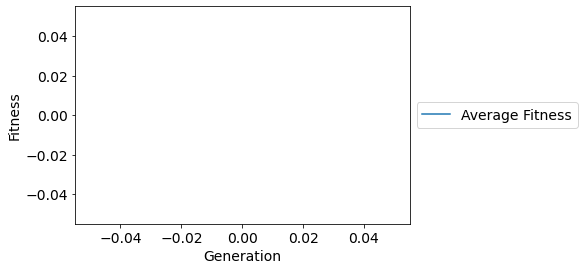

In [15]:
# Sets the header & statistics to select from logbook
logbook.header = "gen", "avg", "evals", "std", "min", "max"
gen, _min, _max, average, standard_dev = logbook.select("gen", "min", "max", "avg", "std")

# Draws graphs 
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax = plt.subplots()

ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")

line1 = ax.plot(gen, average)
line2 = ax.plot(gen, _min)
line3 = ax.plot(gen, _max)

# Adds key to graph
ax.legend(["Average Fitness", "Minimum Fitness", "Maximum Fitness"], loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
# Takes weights of the best individual and runs in non-headless mode
bestInd = tools.selBest(population, 1)[0]

# Saves best individual to a file
current_date_and_time_string = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_name = "best_individuals//"  + current_date_and_time_string + ".pkl"
open_file = open(file_name, "wb")
pickle.dump(bestInd, open_file)
open_file.close()


In [11]:
def run_best_ind(filename): # Loads best individual and runs in non-headless
    display = DisplayGame(XSIZE,YSIZE)
    open_file = open(filename, "rb")
    bestInd = pickle.load(open_file)
    network.setWeightsLinear(bestInd)
    run_game(display, snake_game, False, network)

In [13]:
run_best_ind("best_individuals//20220224-233335.pkl")

Terminator: 